# Derive equation of the best-fit ellipse to the base track angular distribution of data

This follows the method outlined in https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html

In [9]:
# start with the necessary imports
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
import numpy as np
import matplotlib as mpl
import uproot
import awkward as ak
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import math

import matplotlib as mpl
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

### Simulated Sample 
This sample is smaller and less computationally intensive than the data, so it is useful to test the algorithm. Sample production code provided by Oliver.

In [2]:
true_dist = multivariate_normal(mean=[1, 3], cov=[[9, 3], [3, 16]])

In [3]:
samples = 10000
xy = true_dist.rvs(samples)

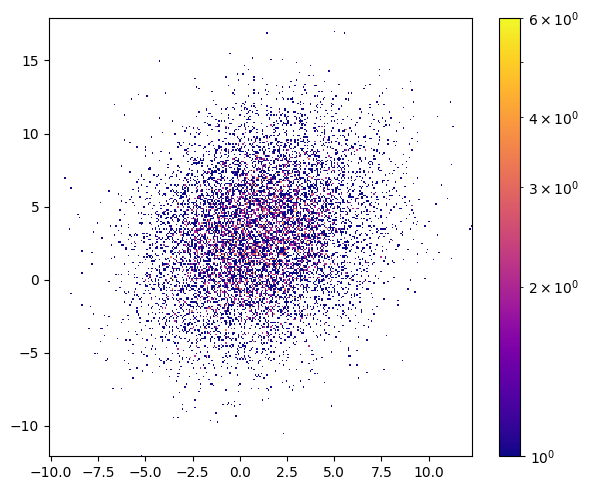

In [188]:
fig, ax = plt.subplots(1, figsize=(6, 5), tight_layout=True)

hist = ax.hist2d([i for [i, j] in xy], [j for [i, j] in xy], bins=300, cmap=mpl.colormaps['plasma'], norm= mpl.colors.LogNorm())
fig.colorbar(hist[3], ax=ax)

fig.tight_layout()
plt.show()

### Real Sample

Load the data - Run 1, b000044, cell (8, 13). Only select the good vertices, with z-position of vtx in brick, at least 3 tracks, and flag 0 or 3.

In [2]:
d_nocut_path = '/eos/user/t/tkrishna/data_vtxfiles/vertextree_nocut.root'

branchnames = ['vID', 'vz', 'flag', 'n', 's/s.eTX', 's/s.eTY', 's/s.eZ', 's/s.ePID', 'nseg', 'npl', 'MCEventID', 'MCTrackID', 'MCTrackPdgCode', 's/s.eID']
# add original file (nocut) to df list
sim_file = uproot.open(d_nocut_path)
sim_tree = sim_file['vtx']
df = sim_tree.arrays(branchnames, library='pd')
df['brickID'] = 11
    
def cut_d(vz, n, flag):
    zmin=-74967.796875
    zmax=0
    return [True if (vz[j]<zmax and vz[j]>zmin and n[j]>=3 and (flag[j]==0 or flag[j]==3)) else False for j in range(len(flag))]

df = df[cut_d(df['vz'], df['n'], df['flag'])]

Get the x and y angles of segments, which is what we want to fit

In [3]:
x = np.asarray(ak.flatten(df['s/s.eTX']))
y = np.asarray(ak.flatten(df['s/s.eTY']))
xy = [[x[i], y[i]] for i in range(len(y))]

Plot the base track angles to see the distribution - asymmetrical and off-center.

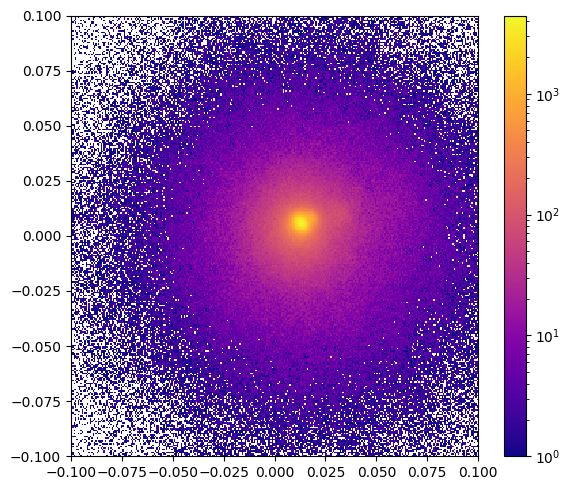

In [6]:
fig, ax = plt.subplots(1, figsize=(6, 5), tight_layout=True)
mval = 0.1
range_ = ((-1*mval, mval), (-1*mval, mval))
hist = ax.hist2d([i for [i, j] in xy], [j for [i, j] in xy], bins=300, cmap=mpl.colormaps['plasma'], norm= mpl.colors.LogNorm(), range=range_)
fig.colorbar(hist[3], ax=ax)
ax.set_xlim(range_[0])
ax.set_ylim(range_[1])

fig.tight_layout()
plt.show()

### Making Confidence Ellipses with matplotlib

First, this is the function for creating a confidence ellipse

In [5]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    mean_x, mean_y: float
        Center of confidence ellipse, mean of input data
        
    pearson: float
        Parameter related to asymmetry of ellipse.
        
    scale_x, scale_y: float
        Scaling factor of ellipse depending on chosen n_std.
        
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    
    ax.add_patch(ellipse)
    return (mean_x, mean_y, pearson, scale_x, scale_y)


We select 3 confidence intervals and plot the resulting ellipses.

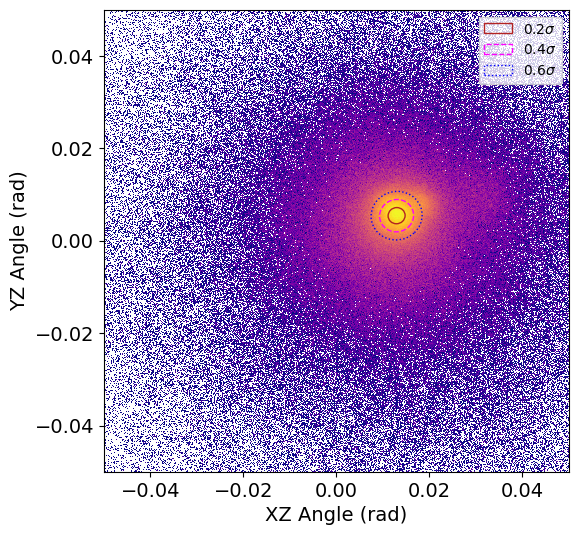

In [6]:
fig, ax_nstd = plt.subplots(figsize=(6, 6))
mval=0.05
range_ = ((-1*mval, mval), (-1*mval, mval))

x = np.asarray([i for [i,j] in xy if math.sqrt((i-0.012)**2 + (j-0.0067)**2)<0.03])
y = np.asarray([j for [i,j] in xy if math.sqrt((i-0.012)**2 + (j-0.0067)**2)<0.03])
ax_nstd.hist2d([i for [i,j] in xy], [j for [i,j] in xy], bins=500, cmap=mpl.colormaps['plasma'], norm= mpl.colors.LogNorm(), range=range_)
#ax_nstd.hist2d(x, y, bins=500, cmap=mpl.colormaps['plasma'], norm= mpl.colors.LogNorm(), range=range_)

e1_vals = confidence_ellipse(x, y, ax_nstd, n_std=0.2, label=r'$0.2\sigma$', edgecolor='firebrick')
e2_vals = confidence_ellipse(x, y, ax_nstd, n_std=0.4, label=r'$0.4\sigma$', edgecolor='fuchsia', linestyle='--')
e3_vals = confidence_ellipse(x, y, ax_nstd, n_std=0.6, label=r'$0.6\sigma$', edgecolor='blue', linestyle=':')


ax_nstd.set_xlabel("XZ Angle (rad)", fontsize=14)
ax_nstd.set_ylabel("YZ Angle (rad)", fontsize=14)


#ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
#ax_nstd.set_title('Different standard deviations')
ax_nstd.legend()
plt.savefig("Figures/AngleCuts/data_CI_cutOptions_AllData.pdf")
plt.show()

We can then recover the equation of the ellipse from the parameters of the confidence ellipse.

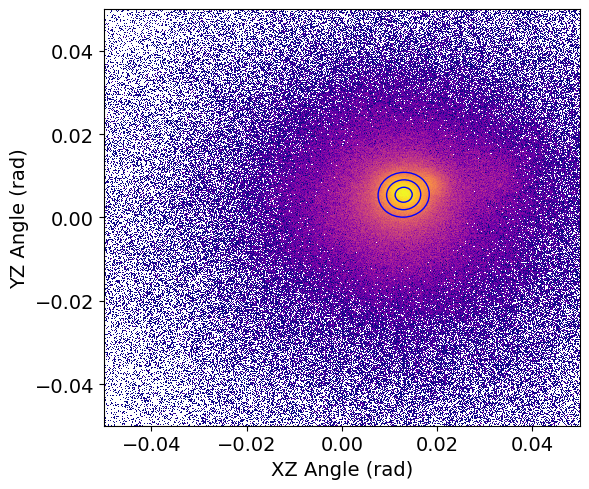

In [15]:
fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
mval=0.05
range_ = ((-1*mval, mval), (-1*mval, mval))
shape = []

ax.hist2d([i for [i,j] in xy], [j for [i,j] in xy], bins=500, cmap=mpl.colormaps['plasma'], norm= mpl.colors.LogNorm(), range=range_)
for val in (e1_vals, e2_vals, e3_vals):
    mean_x, mean_y, p, scale_x, scale_y = val
    angle_ = -math.atan2(scale_y, scale_x)*(180/math.pi)
    length = np.sqrt(scale_x**2 + scale_y**2)*np.sqrt((1+p)*2)
    width = np.sqrt(scale_x**2 + scale_y**2)*np.sqrt((1-p)*2)
    area = math.pi * width * length
    ellipse = Ellipse((mean_x, mean_y), width=width, height=length, angle=angle_, edgecolor='blue', facecolor='none')
    
    shape += [(mean_x, mean_y, width, length, angle_*(math.pi/180))]
    ax.add_patch(ellipse)
    
ax.set_xlabel("XZ Angle (rad)", fontsize=14)
ax.set_ylabel("YZ Angle (rad)", fontsize=14)

ax.autoscale_view()
plt.savefig("Figures/AngleCuts/data_Ellipses_cutOptions_AllData.pdf")
plt.show() 

We can also look at the fitted ellipses alone without the data overlaid.

1.0082142660517188e-05
4.032857064206875e-05
9.073928394465467e-05


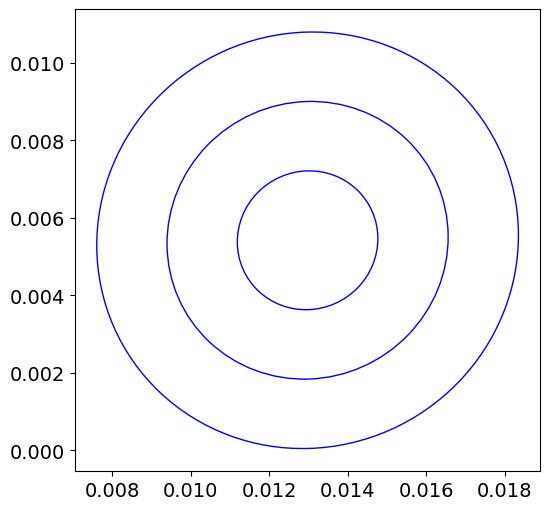

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
shape = []
# ellipse 1:
for val in (e1_vals, e2_vals, e3_vals):
    mean_x, mean_y, p, scale_x, scale_y = val
    angle_ = -math.atan2(scale_y, scale_x)*(180/math.pi)
    length = np.sqrt(scale_x**2 + scale_y**2)*np.sqrt((1+p)*2)
    width = np.sqrt(scale_x**2 + scale_y**2)*np.sqrt((1-p)*2)
    area = math.pi * width/2 * length/2
    print(area)
    ellipse = Ellipse((mean_x, mean_y), width=width, height=length, angle=angle_, edgecolor='blue', facecolor='none')
    
    shape += [(mean_x, mean_y, width, length, angle_)]
    ax.add_patch(ellipse)

ax.autoscale_view()
plt.show() 

The list shape contains the parameters of the 3 ellipses so that we can write their equations

In [26]:
shape

[(0.0129742579338635,
  0.005422891469618028,
  0.003540150600591124,
  0.003626112044184896,
  -0.7638078300687247),
 (0.0129742579338635,
  0.005422891469618028,
  0.007080301201182248,
  0.007252224088369792,
  -0.7638078300687247),
 (0.0129742579338635,
  0.005422891469618028,
  0.01062045180177337,
  0.010878336132554687,
  -0.7638078300687245)]

### Write the equations of the ellipses in the format necessary to input in the track.rootrc file as a cut

In [33]:
for ell in shape:  
    (x, y, w, h, a) = ell
    cos = math.cos(a)
    sin = math.sin(a)

    print("(((s.eTX - "+str(x)+")*("+str(cos)+") - (s.eTY - "+str(y)+")*("+str(sin)+"))**2 / ("+str(h)+"/2)**2 + ((s.eTX - "+str(x)+")* ("+str(sin)+") + (s.eTY - "+str(y)+")* ("+str(cos)+"))**2 / ("+str(w)+"/2)**2)**0.5 > 1")
    print()


(((s.eTX - 0.0129742579338635)*(0.722207466387835) - (s.eTY - 0.005422891469618028)*(-0.6916764962709548))**2 / (0.003626112044184896/2)**2 + ((s.eTX - 0.0129742579338635)* (-0.6916764962709548) + (s.eTY - 0.005422891469618028)* (0.722207466387835))**2 / (0.003540150600591124/2)**2)**0.5 > 1

(((s.eTX - 0.0129742579338635)*(0.722207466387835) - (s.eTY - 0.005422891469618028)*(-0.6916764962709548))**2 / (0.007252224088369792/2)**2 + ((s.eTX - 0.0129742579338635)* (-0.6916764962709548) + (s.eTY - 0.005422891469618028)* (0.722207466387835))**2 / (0.007080301201182248/2)**2)**0.5 > 1

(((s.eTX - 0.0129742579338635)*(0.7222074663878351) - (s.eTY - 0.005422891469618028)*(-0.6916764962709548))**2 / (0.010878336132554687/2)**2 + ((s.eTX - 0.0129742579338635)* (-0.6916764962709548) + (s.eTY - 0.005422891469618028)* (0.7222074663878351))**2 / (0.01062045180177337/2)**2)**0.5 > 1

